<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 02a: PyTorch Lightning

### What You Will Learn

- The core components of a PyTorch Lightning training loop: `LightningModule`s and `Trainer`s.
- Useful quality-of-life improvements offered by PyTorch Lightning: `LightningDataModule`s, `Callback`s, and `Metric`s
- How we use these features in the FSDL codebase

## Setup

If you're running this notebook on Google Colab,
the cell below will run full environment setup.

It should take about three minutes to run.

In [88]:
lab_idx = 2

if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

/home/terps/.git/fsdl-text-recognizer-2022-labs/lab02
lightning_logs/  notebooks/  text_recognizer/  training/


# Why Lightning?

PyTorch is a powerful library for executing differentiable
tensor operations with hardware acceleration
and it includes many neural network primitives,
but it has no concept of "training".
At a high level, an `nn.Module` is a stateful function with gradients
and a `torch.optim.Optimizer` can update that state using gradients,
but there's no pre-built tools in PyTorch to iteratively generate those gradients from data.

So the first thing many folks do in PyTorch is write that code --
a "training loop" to iterate over their `DataLoader`,
which in pseudocode might look something like:

```python
for batch in dataloader:
    inputs, targets = batch

    outputs = model(inputs)
    loss = some_loss_function(inputs, outputs)
    
    optimizer.zero_gradients()
    loss.backward()

    optimizer.step()
```

This is a solid start, but other needs immediately arise.
You'll want to run your model on validation and test data,
which need their own `DataLoader`s.
Once finished, you'll want to save your model --
and for long-running jobs, you probably want
to save checkpoints of the training process
so that it can be resumed in case of a crash.
For state-of-the-art model performance in many domains,
you'll want to distribute your training across multiple nodes/machines
and across multiple GPUs within those nodes.

That's just the tip of the iceberg, and you want
all those features to work for lots of models and datasets,
not just the one you're writing now

You don't want to write all of this yourself.

So unless you are at a large organization that has a dedicated team
for building that "framework" code,
you'll want to use an existing library.

PyTorch Lightning is a popular framework on top of PyTorch.

In [89]:
import pytorch_lightning as pl

version = pl.__version__

docs_url = f"https://pytorch-lightning.readthedocs.io/en/{version}/"  # version can also be latest, stable
docs_url

'https://pytorch-lightning.readthedocs.io/en/1.6.3/'

At its core, PyTorch Lightning provides

1. the `pl.Trainer` class, which organizes and executes your training, validation, and test loops, and
2. the `pl.LightningModule` class, which links optimizers to models and defines how the model behaves during training, validation, and testing.

Both of these are kitted out with all the features
a cutting-edge deep learning codebase needs:
- flags for switching device types and distributed computing strategy
- saving, checkpointing, and resumption
- calculation and logging of metrics

and much more.

Importantly these features can be easily
added, removed, extended, or bypassed
as desired, meaning your code isn't constrained by the framework.

In some ways, you can think of Lightning as a tool for "organizing" your PyTorch code,
as shown in the video below.

In [90]:
import IPython.display as display


display.IFrame(src="https://pl-bolts-doc-images.s3.us-east-2.amazonaws.com/pl_docs/pl_mod_vid.m4v",
               width=720, height=720)

That's opposed to the other way frameworks are designed,
to provide abstractions over the lower-level library
(here, PyTorch).

Because of this "organize don't abstract" style,
writing PyTorch Lightning code involves
a lot of over-riding of methods --
you inherit from a class
and then implement the specific version of a general method
that you need for your code,
rather than Lightning providing a bunch of already
fully-defined classes that you just instantiate,
using arguments for configuration.

# The `pl.LightningModule`

The first of our two core classes,
the `LightningModule`,
is like a souped-up `torch.nn.Module` --
it inherits all of the `Module` features,
but adds more.

In [91]:
import torch


issubclass(pl.LightningModule, torch.nn.Module)

True

To demonstrate how this class works,
we'll build up a `LinearRegression` model dynamically,
method by method.

For this example we hard code lots of the details,
but the real benefit comes when the details are configurable.

In order to have a realistic example as well,
we'll compare to the actual code
in the `BaseLitModel` we use in the codebase
as we go.

In [92]:
from text_recognizer.lit_models import BaseLitModel

In [93]:
BaseLitModel??

A `pl.LightningModule` is a `torch.nn.Module`,
so the basic definition looks the same:
we need `__init__` and `forward`.

In [94]:
class LinearRegression(pl.LightningModule):

    def __init__(self):
        super().__init__()  # just like in torch.nn.Module, we need to call the parent class __init__

        # attach torch.nn.Modules as top level attributes during init, just like in a torch.nn.Module
        self.model = torch.nn.Linear(in_features=1, out_features=1)
        # we like to define the entire model as one torch.nn.Module -- typically in a separate class

    # optionally, define a forward method
    def forward(self, xs):
        return self.model(xs)  # we like to just call the model's forward method

But just the minimal definition for a `torch.nn.Module` isn't sufficient

If we try to use the class above with the `Trainer`, we get an error:

In [95]:
import logging  # import some stdlib components to control what's display
import textwrap
import traceback


try:  # try using the LinearRegression LightningModule defined above
    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)  # hide some info for now

    model = LinearRegression()

    # we'll explain how the Trainer works in a bit
    trainer = pl.Trainer(gpus=int(torch.cuda.is_available()), max_epochs=1)
    trainer.fit(model=model)  

except pl.utilities.exceptions.MisconfigurationException as error:
    print("Error:", *textwrap.wrap(str(error), 80), sep="\n\t")  # show the error without raising it

finally:  # bring back info-level logging
    logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

Error:
	No `training_step()` method defined. Lightning `Trainer` expects as minimum a
	`training_step()`, `train_dataloader()` and `configure_optimizers()` to be
	defined.


The error message says we need some more methods.

Two of them are mandatory components of the `LightningModule`: `.training_step` and `.configure_optimizers`.

#### `.training_step`

The `training_step` method defines,
naturally enough,
what to do during a single step of training.

Roughly, it gets used like this:

```python

# pseudocode modified from the Lightning documentation

# put model in train mode
model.train()

for batch in train_dataloader:
    # run the train step
    loss = training_step(batch)

    # clear gradients
    optimizer.zero_grad()

    # backprop
    loss.backward()

    # update parameters
    optimizer.step()
```

Effectively, it maps a batch to a loss value,
so that PyTorch can backprop through that loss.

The `.training_step` for our `LinearRegression` model is straightforward:

In [96]:
from typing import Tuple


def training_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    xs, ys = batch  # unpack the batch
    outs = self(xs)  # apply the model
    loss = torch.nn.functional.mse_loss(outs, ys)  # compute the (squared error) loss
    return loss


LinearRegression.training_step = training_step

If you've written PyTorch code before, you'll notice that we don't mention devices
or other tensor metadata here -- that's handled for us by Lightning, which is a huge relief.

You can additionally define
a `validation_step` and a `test_step`
to define the model's behavior during
validation and testing loops.

You're invited to define these steps
in the exercises at the end of the lab.

Inside this step is also where you might calculate other
values related to inputs, outputs, and loss,
like non-differentiable metrics (e.g. accuracy, precision, recall).

So our `BaseLitModel`'s got a slightly more complex `training_step` method,
and the details of the forward pass are deferred to `._run_on_batch` instead.

In [97]:
BaseLitModel.training_step??

#### `.configure_optimizers`

Thanks to `training_step` we've got a loss, and PyTorch can turn that into a gradient.

But we need more than a gradient to do an update.

We need an _optimizer_ that can make use of the gradients to update the parameters. In complex cases, we might need more than one optimizer (e.g. GANs).

Our second required method, `.configure_optimizers`,
sets up the `torch.optim.Optimizer`s 
(e.g. setting their hyperparameters
and pointing them at the `Module`'s parameters).

In psuedo-code (modified from the Lightning documentation), it gets used something like this:

```python
optimizer = model.configure_optimizers()

for batch_idx, batch in enumerate(data):

    def closure():  # wrap the loss calculation
        loss = model.training_step(batch, batch_idx, ...)
        optimizer.zero_grad()
        loss.backward()
        return loss

    # optimizer can call the loss calculation as many times as it likes
    optimizer.step(closure)  # some optimizers need this, like (L)-BFGS
```

For our `LinearRegression` model,
we just need to instantiate an optimizer and point it at the parameters of the model:

In [98]:
def configure_optimizers(self: LinearRegression) -> torch.optim.Optimizer:
    optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)  # https://fsdl.me/ol-reliable-img
    return optimizer


LinearRegression.configure_optimizers = configure_optimizers

You can read more about optimization in Lightning,
including how to manually control optimization
instead of relying on default behavior,
in the docs:

In [99]:
optimization_docs_url = f"https://pytorch-lightning.readthedocs.io/en/{version}/common/optimization.html"
optimization_docs_url

'https://pytorch-lightning.readthedocs.io/en/1.6.3/common/optimization.html'

The `configure_optimizers` method for the `BaseLitModel`
isn't that much more complex.

We just add support for learning rate schedulers:


In [100]:
BaseLitModel.configure_optimizers??

# The `pl.Trainer`

The `LightningModule` has already helped us organize our code,
but it's not really useful until we combine it with the `Trainer`,
which relies on the `LightningModule` interface to execute training, validation, and testing.

The `Trainer` is where we make choices like how long to train
(`max_epochs`, `min_epochs`, `max_time`, `max_steps`),
what kind of acceleration (e.g. `gpus`) or distribution strategy to use,
and other settings that might differ across training runs.

In [101]:
trainer = pl.Trainer(max_epochs=20, gpus=int(torch.cuda.is_available()))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Before we can actually use the `Trainer`, though,
we also need a `torch.utils.data.DataLoader` --
nothing new from PyTorch Lightning here,
just vanilla PyTorch.

In [102]:
class CorrelatedDataset(torch.utils.data.Dataset):

    def __init__(self, N=10_000):
        self.N = N
        self.xs = torch.randn(size=(N, 1))
        self.ys = torch.randn_like(self.xs) + self.xs  # correlated target data: y ~ N(x, 1)

    def __getitem__(self, idx):
        return (self.xs[idx], self.ys[idx])

    def __len__(self):
        return self.N


dataset = CorrelatedDataset()
tdl = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1)

We can fetch some sample data from the `DataLoader`:

In [103]:
example_xs, example_ys = next(iter(tdl))  # grabbing an example batch to print

print("xs:", example_xs[:10], sep="\n")
print("ys:", example_ys[:10], sep="\n")

xs:
tensor([[ 0.7050],
        [ 0.8957],
        [-0.5907],
        [ 0.2700],
        [ 0.7807],
        [ 0.3557],
        [-0.7801],
        [ 1.6291],
        [-0.5134],
        [-1.2589]])
ys:
tensor([[ 2.7289],
        [ 1.9972],
        [-1.8257],
        [ 0.6683],
        [ 1.6347],
        [ 0.3452],
        [-0.7775],
        [ 2.3807],
        [ 0.2938],
        [-1.3626]])


and, since it's low-dimensional, visualize it
and see what we're asking the model to learn:

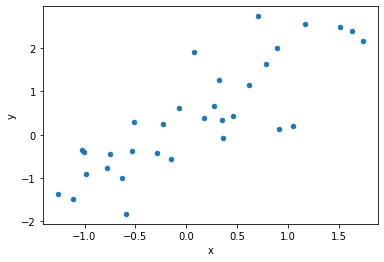

In [104]:
import pandas as pd


pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", kind="scatter");

Now we're ready to run training:

In [105]:
model = LinearRegression()

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer.fit(model=model, train_dataloaders=tdl)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


loss before training: 1.5908552408218384


Training: 0it [00:00, ?it/s]

loss after training: 0.9749365448951721


The loss after training should be less than the loss before training,
and we can see that our model's predictions line up with the data:

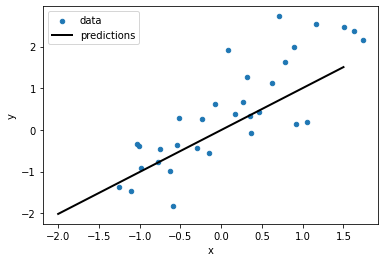

In [106]:
ax = pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", legend=True, kind="scatter", label="data")

inps = torch.arange(-2, 2, 0.5)[:, None]
ax.plot(inps, model(inps).detach(), lw=2, color="k", label="predictions"); ax.legend();

The `Trainer` promises to "customize every aspect of training via flags":

In [107]:
pl.Trainer.__init__.__doc__.strip().split("\n")[0]

'Customize every aspect of training via flags.'

and they mean _every_ aspect.

The cell below prints all of the arguments for the `pl.Trainer` class --
no need to memorize or even understand them all now,
just skim it to see how many customization options there are:

In [108]:
print(pl.Trainer.__init__.__doc__)


        Customize every aspect of training via flags.

        Args:

            accelerator: Supports passing different accelerator types ("cpu", "gpu", "tpu", "ipu", "hpu", "auto")
                as well as custom accelerator instances.

                .. deprecated:: v1.5
                    Passing training strategies (e.g., 'ddp') to ``accelerator`` has been deprecated in v1.5.0
                    and will be removed in v1.7.0. Please use the ``strategy`` argument instead.

            accumulate_grad_batches: Accumulates grads every k batches or as set up in the dict.
                Default: ``None``.

            amp_backend: The mixed precision backend to use ("native" or "apex").
                Default: ``'native''``.

            amp_level: The optimization level to use (O1, O2, etc...). By default it will be set to "O2"
                if ``amp_backend`` is set to "apex".

            auto_lr_find: If set to True, will make trainer.tune() run a learning rate finder,
 

It's probably easier to read them on the documentation website:

In [109]:
trainer_docs_link = f"https://pytorch-lightning.readthedocs.io/en/{version}/common/trainer.html"
trainer_docs_link

'https://pytorch-lightning.readthedocs.io/en/1.6.3/common/trainer.html'

# Training with PyTorch Lightning in the FSDL Codebase

The `LightningModule`s in the FSDL codebase
are stored in the `lit_models` submodule of the `text_recognizer` module.

For now, we've just got some basic models.
We'll add more as we go.

In [110]:
!ls text_recognizer/lit_models

__init__.py  __pycache__  base.py


We also have a folder called `training` now.

This contains a script, `run_experiment.py`,
that is used for running training jobs.

In case you want to play around with the training code
in a notebook, you can also load it as a module:

In [111]:
!ls training

__init__.py  __pycache__  run_experiment.py  util.py


In [112]:
import training.run_experiment


print(training.run_experiment.__doc__, training.run_experiment.main.__doc__)

Experiment-running framework. 
    Run an experiment.

    Sample command:
    ```
    python training/run_experiment.py --max_epochs=3 --gpus='0,' --num_workers=20 --model_class=MLP --data_class=MNIST
    ```

    For basic help documentation, run the command
    ```
    python training/run_experiment.py --help
    ```

    The available command line args differ depending on some of the arguments, including --model_class and --data_class.

    To see which command line args are available and read their documentation, provide values for those arguments
    before invoking --help, like so:
    ```
    python training/run_experiment.py --model_class=MLP --data_class=MNIST --help
    


We build the `Trainer` from command line arguments:

In [113]:
# how the trainer is initialized in the training script
!grep "pl.Trainer.from" training/run_experiment.py

    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks, logger=logger)


so all the configuration flexibility and complexity of the `Trainer`
is available via the command line.

Docs for the command line arguments for the trainer are accessible with `--help`:

In [114]:
# displays the first few flags for controlling the Trainer from the command line
!python training/run_experiment.py --help | grep "pl.Trainer" -A 24

Traceback (most recent call last):
  File "/home/terps/.git/fsdl-text-recognizer-2022-labs/lab02/training/run_experiment.py", line 6, in <module>
    import pytorch_lightning as pl
ModuleNotFoundError: No module named 'pytorch_lightning'


We'll use `run_experiment` in
[Lab 02b](http://fsdl.me/lab02b-colab)
to train convolutional neural networks.

# Extra Goodies

The `LightningModule` and the `Trainer` are the minimum amount you need
to get started with PyTorch Lightning.

But they aren't all you need.

There are many more features built into Lightning and its ecosystem.

We'll cover three more here:
- `pl.LightningDataModule`s, for organizing dataloaders and handling data in distributed settings
- `pl.Callback`s, for adding "optional" extra features to model training
- `torchmetrics`, for efficiently computing and logging 

## `pl.LightningDataModule`

Where the `LightningModule` organizes our model and its optimizers,
the `LightningDataModule` organizes our dataloading code.

The class-level docstring explains the concept
behind the class well
and lists the main methods to be over-ridden:

In [115]:
print(pl.LightningDataModule.__doc__)

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main
    advantage is consistent data splits, data preparation and transforms across models.

    Example::

        class MyDataModule(LightningDataModule):
            def __init__(self):
                super().__init__()
            def prepare_data(self):
                # download, split, etc...
                # only called on 1 GPU/TPU in distributed
            def setup(self, stage):
                # make assignments here (val/train/test split)
                # called on every process in DDP
            def train_dataloader(self):
                train_split = Dataset(...)
                return DataLoader(train_split)
            def val_dataloader(self):
                val_split = Dataset(...)
                return DataLoader(val_split)
            def test_dataloader(self):
                test_split = Dataset(...)
                return DataLoader(test_split)
            def

Let's upgrade our `CorrelatedDataset` from a PyTorch `Dataset` to a `LightningDataModule`.

In [116]:
import math


class CorrelatedDataModule(pl.LightningDataModule):

    def __init__(self, size=10_000, train_frac=0.8, batch_size=32):
        super().__init__()  # again, mandatory superclass init, as with torch.nn.Modules

        # set some constants, like the train/val split
        self.size = size
        self.train_frac, self.val_frac = train_frac, 1 - train_frac
        self.train_indices = list(range(math.floor(self.size * train_frac)))
        self.val_indices = list(range(self.train_indices[-1], self.size))

        # under the hood, we've still got a torch Dataset
        self.dataset = CorrelatedDataset(N=size)

`LightningDataModule`s are designed to work in distributed settings,
where operations that set state
(e.g. writing to disk or attaching something to `self` that you want to access later)
need to be handled with care.

Getting data ready for training is often a very stateful operation,
so the `LightningDataModule` provides two separate methods for it:
one called `setup` that handles any state that needs to be set up in each copy of the module
(here, splitting the data and adding it to `self`)
and one called `prepare_data` that handles any state that only needs to be set up in each machine
(for example, downloading data from storage and writing it to the local disk).

In [117]:
def setup(self, stage=None):  # prepares state that needs to be set for each GPU on each node
    if stage == "fit" or stage is None:  # other stages: "test", "predict"
        self.train_dataset = torch.utils.data.Subset(self.dataset, self.train_indices)
        self.val_dataset = torch.utils.data.Subset(self.dataset, self.val_indices)

def prepare_data(self):  # prepares state that needs to be set once per node
    pass  # but we don't have any "node-level" computations


CorrelatedDataModule.setup, CorrelatedDataModule.prepare_data = setup, prepare_data

We then define methods to return `DataLoader`s when requested by the `Trainer`.

To run a testing loop that uses a `LightningDataModule`,
you'll also need to define a `test_dataloader`.

In [118]:
def train_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.train_dataset, batch_size=32)

def val_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.val_dataset, batch_size=32)

CorrelatedDataModule.train_dataloader, CorrelatedDataModule.val_dataloader = train_dataloader, val_dataloader

Now we're ready to run training using a datamodule:

In [119]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))
trainer.fit(model=model, datamodule=datamodule)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


loss before training: 1.512824296951294


Training: 0it [00:00, ?it/s]

loss after training: 1.0377525091171265


Notice the warning: "`Skipping val loop.`"

It's being raised because our minimal `LinearRegression` model
doesn't have a `.validation_step` method.

In the exercises, you're invited to add a validation step and resolve this warning.

In the FSDL codebase,
we define the basic functions of a `LightningDataModule`
in the `BaseDataModule` and defer details to subclasses:

In [120]:
from text_recognizer.data import BaseDataModule


BaseDataModule??

In [121]:
from text_recognizer.data.mnist import MNIST


MNIST??

## `pl.Callback`

Lightning's `Callback` class is used to add "nice-to-have" features
to training, validation, and testing
that aren't strictly necessary for any model to run
but are useful for many models.

A "callback" is a unit of code that's meant to be called later,
based on some trigger.

It's a very flexible system, which is why
`Callback`s are used internally to implement lots of important Lightning features,
including some we've already discussed, like `ModelCheckpoint` for saving during training:

In [122]:
pl.callbacks.__all__  # builtin Callbacks from Lightning

['BackboneFinetuning',
 'BaseFinetuning',
 'Callback',
 'DeviceStatsMonitor',
 'EarlyStopping',
 'GPUStatsMonitor',
 'XLAStatsMonitor',
 'GradientAccumulationScheduler',
 'LambdaCallback',
 'LearningRateMonitor',
 'ModelCheckpoint',
 'ModelPruning',
 'ModelSummary',
 'BasePredictionWriter',
 'ProgressBar',
 'ProgressBarBase',
 'QuantizationAwareTraining',
 'RichModelSummary',
 'RichProgressBar',
 'StochasticWeightAveraging',
 'Timer',
 'TQDMProgressBar']

The triggers, or "hooks", here, are specific points in the training, validation, and testing loop.

The names of the hooks generally explain when the hook will be called,
but you can always check the documentation for details.

In [123]:
hooks = ", ".join([method for method in dir(pl.Callback) if method.startswith("on_")])
print("hooks:", *textwrap.wrap(hooks, width=80), sep="\n\t")

hooks:
	on_after_backward, on_batch_end, on_batch_start,
	on_before_accelerator_backend_setup, on_before_backward,
	on_before_optimizer_step, on_before_zero_grad, on_configure_sharded_model,
	on_epoch_end, on_epoch_start, on_exception, on_fit_end, on_fit_start,
	on_init_end, on_init_start, on_keyboard_interrupt, on_load_checkpoint,
	on_predict_batch_end, on_predict_batch_start, on_predict_end,
	on_predict_epoch_end, on_predict_epoch_start, on_predict_start,
	on_pretrain_routine_end, on_pretrain_routine_start, on_sanity_check_end,
	on_sanity_check_start, on_save_checkpoint, on_test_batch_end,
	on_test_batch_start, on_test_end, on_test_epoch_end, on_test_epoch_start,
	on_test_start, on_train_batch_end, on_train_batch_start, on_train_end,
	on_train_epoch_end, on_train_epoch_start, on_train_start,
	on_validation_batch_end, on_validation_batch_start, on_validation_end,
	on_validation_epoch_end, on_validation_epoch_start, on_validation_start


You can define your own `Callback` by inheriting from `pl.Callback`
and over-riding one of the "hook" methods --
much the same way that you define your own `LightningModule`
by writing your own `.training_step` and `.configure_optimizers`.

Let's define a silly `Callback` just to demonstrate the idea:

In [124]:
class HelloWorldCallback(pl.Callback):

    def on_train_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the start of the training epoch!")

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the end of the validation epoch!")

This callback will print a message whenever the training epoch starts
and whenever the validation epoch ends.

Different "hooks" have different information directly available.

For example, you can directly access the batch information
inside the `on_train_batch_start` and `on_train_batch_end` hooks:

In [125]:
import random


def on_train_batch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        if random.random() > 0.995:
            print(f"👋 hello from inside the lucky batch, #{batch_idx}!")


HelloWorldCallback.on_train_batch_start = on_train_batch_start

We provide the callbacks when initializing the `Trainer`,
then they are invoked during model fitting.

In [126]:
model = LinearRegression()

datamodule = CorrelatedDataModule()

trainer = pl.Trainer(  # we instantiate and provide the callback here, but nothing happens yet
    max_epochs=10, gpus=int(torch.cuda.is_available()), callbacks=[HelloWorldCallback()])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [127]:
trainer.fit(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #59!
👋 hello from inside the lucky batch, #80!
👋 hello from inside the lucky batch, #231!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #66!
👋 hello from inside the lucky batch, #92!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #204!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #86!
👋 hello from the start of the training epoch!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #39!
👋 hello from inside the lucky batch, #145!
👋 hello from inside the lucky batch, #221!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #68!
👋 hello from inside the lucky batch, #104!
👋 hello from inside the lucky batch, #146!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #141!
👋 hello from the start of the trainin

You can read more about callbacks in the documentation:

In [128]:
callback_docs_url = f"https://pytorch-lightning.readthedocs.io/en/{version}/extensions/callbacks.html"
callback_docs_url

'https://pytorch-lightning.readthedocs.io/en/1.6.3/extensions/callbacks.html'

## `torchmetrics`

DNNs are also finicky and break silently:
rather than crashing, they just start doing the wrong thing.
Without careful monitoring, that wrong thing can be invisible
until long after it has done a lot of damage to you, your team, or your users.

We want to calculate metrics so we can monitor what's happening during training and catch bugs --
or even achieve ["observability"](https://thenewstack.io/observability-a-3-year-retrospective/),
meaning we can also determine
how to fix bugs in training just by viewing logs.

But DNN training is also performance sensitive.
Training runs for large language models have budgets that are
more comparable to building an apartment complex
than they are to the build jobs of traditional software pipelines.

Slowing down training even a small amount can add a substantial dollar cost,
obviating the benefits of catching and fixing bugs more quickly.

Also implementing metric calculation during training adds extra work,
much like the other software engineering best practices which it closely resembles,
namely test-writing and monitoring.
This distracts and detracts from higher-leverage research work.


The `torchmetrics` library, which began its life as `pytorch_lightning.metrics`,
resolves these issues by providing a `Metric` class that
incorporates best performance practices,
like smart accumulation across batches and over devices,
defines a unified interface,
and integrates with Lightning's built-in logging.

In [129]:
import torchmetrics


tm_version = torchmetrics.__version__
print("metrics:", *textwrap.wrap(", ".join(torchmetrics.__all__), width=80), sep="\n\t")

metrics:
	functional, Accuracy, AUC, AUROC, AveragePrecision, BinnedAveragePrecision,
	BinnedPrecisionRecallCurve, BinnedRecallAtFixedPrecision, BLEUScore,
	BootStrapper, CalibrationError, CatMetric, CHRFScore, CohenKappa,
	ConfusionMatrix, CosineSimilarity, TweedieDevianceScore, ExplainedVariance,
	ExtendedEditDistance, F1, F1Score, FBeta, FBetaScore, HammingDistance, Hinge,
	HingeLoss, JaccardIndex, KLDivergence, MatthewsCorrcoef, MatthewsCorrCoef,
	MaxMetric, MeanAbsoluteError, MeanAbsolutePercentageError, MeanMetric,
	MeanSquaredError, MeanSquaredLogError, Metric, MetricCollection, MetricTracker,
	MinMaxMetric, MinMetric, MultioutputWrapper,
	MultiScaleStructuralSimilarityIndexMeasure, PearsonCorrcoef, PearsonCorrCoef,
	PermutationInvariantTraining, PIT, Precision, PrecisionRecallCurve, PSNR,
	PeakSignalNoiseRatio, R2Score, Recall, RetrievalFallOut, RetrievalHitRate,
	RetrievalMAP, RetrievalMRR, RetrievalNormalizedDCG, RetrievalPrecision,
	RetrievalRecall, RetrievalRPrecision, ROC,

Like the `LightningModule`, `torchmetrics.Metric` inherits from `torch.nn.Module`.

That's because metric calculation, like module application, is typically
1) an array-heavy computation that
2) relies on persistent state
(parameters for `Module`s, running values for `Metric`s) and
3) benefits from acceleration and
4) can be distributed over devices and nodes.

In [130]:
issubclass(torchmetrics.Metric, torch.nn.Module)

True

Documentation for the version of `torchmetrics` we're using can be found here:

In [131]:
torchmetrics_docs_url = f"https://torchmetrics.readthedocs.io/en/v{tm_version}/"
torchmetrics_docs_url

'https://torchmetrics.readthedocs.io/en/v0.7.3/'

In the `BaseLitModel`,
we use the `torchmetrics.Accuracy` metric:

In [132]:
BaseLitModel??

# Exercises

### 🌟 Add a `validation_step` to the `LinearRegression` class.

In [133]:
pl.LightningModule??

In [134]:
import torch.nn.functional as F
def validation_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    x, y = batch
    #xs = self(x)
    loss = torch.mean(torch.square(model(x) - y)).item()
    pred = ...
    self.log("val_loss", loss, prog_bar=True)
    return{"val_loss": loss, "pred": pred}


LinearRegression.validation_step = validation_step

In [135]:
LinearRegression??

In [136]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))
# if you code is working, you should see results for the validation loss in the output
trainer.fit(model=model, datamodule=datamodule)
#trainer.validate(model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### 🌟🌟 Add a `test_step` to the `LinearRegression` class and a `test_dataloader` to the `CorrelatedDataModule`.

In [137]:
model??

In [138]:
def test_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    x, y = batch
    loss = torch.mean(torch.square(model(x) - y)).item()
    pred = ...
    self.log("val_loss", loss, prog_bar=True)
    return{"test_loss": loss, "pred": pred}

LinearRegression.test_step = test_step

In [139]:
class CorrelatedDataModuleWithTest(pl.LightningDataModule):

    def __init__(self, N=10_000, N_test=10_000):  # reimplement __init__ here
        super().__init__()  # don't forget this!
        self.dataset = CorrelatedDataset(N=N)
        self.test_dataset = CorrelatedDataset(N=N_test)  # define a test set -- another sample from the same distribution

    def setup(self, stage=None):
        pass

    def test_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=32)

In [140]:
model = LinearRegression()
datamodule = CorrelatedDataModuleWithTest()

dataset = datamodule.dataset

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))

# we run testing without fitting here
trainer.test(model=model, datamodule=datamodule)  # if your code is working, you should see performance on the test set here

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.6310670375823975
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.6310670375823975}]

### 🌟🌟🌟 Make a version of the `LinearRegression` class that calculates the `ExplainedVariance` metric during training and validation.

The "variance explained" is a useful metric for comparing regression models --
its values are interpretable and comparable across datasets, unlike raw loss values.



Read the "TorchMetrics in PyTorch Lightning" guide for details on how to
add metrics and metric logging
to a `LightningModule`:

In [141]:
torchmetrics_guide_url = f"https://torchmetrics.readthedocs.io/en/v{tm_version}/pages/lightning.html"
torchmetrics_guide_url

'https://torchmetrics.readthedocs.io/en/v0.7.3/pages/lightning.html'

And check out the docs for `ExplainedVariance` to see how it's calculated:

In [142]:
print(torchmetrics.ExplainedVariance.__doc__)


    Computes `explained variance`_:

    .. math:: \text{ExplainedVariance} = 1 - \frac{\text{Var}(y - \hat{y})}{\text{Var}(y)}

    Where :math:`y` is a tensor of target values, and :math:`\hat{y}` is a
    tensor of predictions.

    Forward accepts

    - ``preds`` (float tensor): ``(N,)`` or ``(N, ...)`` (multioutput)
    - ``target`` (long tensor): ``(N,)`` or ``(N, ...)`` (multioutput)

    In the case of multioutput, as default the variances will be uniformly
    averaged over the additional dimensions. Please see argument `multioutput`
    for changing this behavior.

    Args:
        multioutput:
            Defines aggregation in the case of multiple output scores. Can be one
            of the following strings (default is `'uniform_average'`.):

            * `'raw_values'` returns full set of scores
            * `'uniform_average'` scores are uniformly averaged
            * `'variance_weighted'` scores are weighted by their individual variances

        compute_on_step

You'll want to start the `LinearRegression` class over from scratch,
since the `__init__` and `{training, validation, test}_step` methods need to be rewritten.

In [147]:
class LinearRegression(pl.LightningModule):

    def __init__(self):
        super().__init__()  # just like in torch.nn.Module, we need to call the parent class __init__

        # attach torch.nn.Modules as top level attributes during init, just like in a torch.nn.Module
        self.model = torch.nn.Linear(in_features=1, out_features=1)
        # we like to define the entire model as one torch.nn.Module -- typically in a separate class
        self.explained_variance = torchmetrics.ExplainedVariance()

    # optionally, define a forward method
    def forward(self, xs):
        return self.model(xs)  # we like to just call the model's forward method
    
    def training_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        xs, ys = batch  # unpack the batch
        outs = self(xs)  # apply the model
        loss = torch.nn.functional.mse_loss(outs, ys)  # compute the (squared error) loss
        self.explained_variance(outs, ys)
        self.log('train_ev_step', self.explained_variance, prog_bar=True)
        return loss
    
    def validation_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        xs, ys = batch  # unpack the batch
        outs = self(xs)  # apply the model
        loss = torch.nn.functional.mse_loss(outs, ys)  # compute the (squared error) loss
        self.explained_variance(outs, ys)
        self.log('val_ev_step', self.explained_variance, prog_bar=True)
        return loss
    
    def test_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        xs, ys = batch  # unpack the batch
        outs = self(xs)  # apply the model
        loss = torch.nn.functional.mse_loss(outs, ys)  # compute the (squared error) loss
        self.explained_variance(outs, ys)
        self.log('test_ev_step', self.explained_variance, prog_bar=True)
        return loss
    
    def configure_optimizers(self: LinearRegression) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)  # https://fsdl.me/ol-reliable-img
        return optimizer

You can test your code by running fitting and testing.

To see whether it's working,
[call `self.log` inside the `_step` methods](https://torchmetrics.readthedocs.io/en/v0.7.1/pages/lightning.html)
with the
[keyword argument `prog_bar=True`](https://pytorch-lightning.readthedocs.io/en/1.6.1/api/pytorch_lightning.core.LightningModule.html#pytorch_lightning.core.LightningModule.log).
You should see the explained variance show up in the output alongside the loss.

In [148]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))

# if your code is working, you should see explained variance in the progress bar/logs
trainer.fit(model=model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params
---------------------------------------------------------
0 | model              | Linear            | 2     
1 | explained_variance | ExplainedVariance | 0     
---------------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]